# Unit 4 Project: Using Hierarchies to Account for Dependence Between Groups

**Task**:

Two parts:

1. Propose a data set that's compatible with a hierarchical model structure built with pymc, and that potentially has some dependence between subgroups within the data set. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a model using pymc within the colab environment, on a data set of your choice, with the following restrictions
- You must have at least one piror and at least one hyperprior.
- Your model must have at least one seperate prior for each subgroup of the data set, and a at least one shared hyperior for all the groups.
- Any student may use the following data set: [basketball2324](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). I recommend trying to model TRB (total rebounds) by player position (pos). Also, I recommend pandas query function to splice and clean the data.



In [3]:
!pip install "preliz[full,notebook]"


import preliz as pz


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


In [4]:
url_data = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
data = pd.read_csv(url_data,dtype={'Pos':'category'})
data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


# Introduction
In this project I wanted to see which position in basketball gets the most amount of blocks and steals on average. In basketball there is an advanced statistic called stocks (blocks + steals). I thought this stat would be interesting to look at because usually guards have more steals and forwards and centers have more blocks, but in today's NBA with a more positionless style of play it's hard to organize specific positions into specific roles.

In [5]:
stocks = data.STL + data.BLK + 1
data.insert(loc=4,column='STKz',value=stocks)


In [6]:
columns = ['Player', 'Pos', 'STKz']
dataSTK = data[columns]
dataSTK

,Player,Pos,STKz
0,Precious Achiuwa,PF-C,115
1,Bam Adebayo,C,148
2,Ochai Agbaji,SG,92
3,Santi Aldama,PF,98
4,Nickeil Alexander-Walker,SG,107
...,...,...,...
567,Thaddeus Young,PF,29
568,Trae Young,PG,84
569,Omer Yurtseven,C,27
570,Cody Zeller,C,15


# Data
I made a data set with just the player, their position, and their stocks. I had to add 1 to every players number because for my model to work every player needs to have a stocks value above 0 and some guys have 0 for both steals and blocks on their 2023-24 season stats.

(0.0, 400.0)

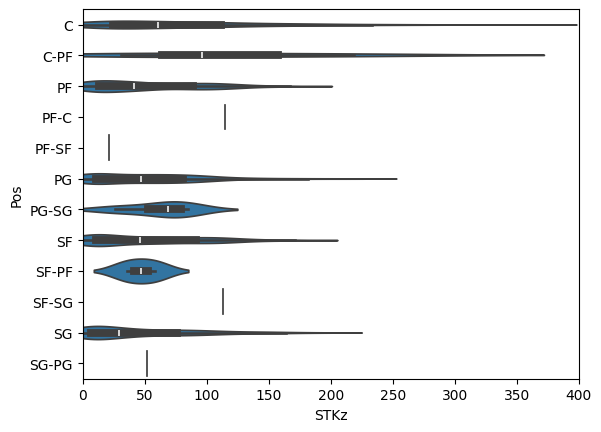

In [32]:
sns.violinplot(dataSTK, x='STKz', y='Pos').set_xlim(0, 400)

In [8]:
pos_idx = dataSTK.Pos.cat.codes.values

pos_codes = data.Pos.cat.categories

stk_coords = {'pos': pos_codes}

# Model
I looked at the violin plot above and used my knowledge of basketball statistics to see that for all positions there is kind of a gamma distribution. More of the players have less stocks and less players have more stocks. It makes sense, as you get better there are less people who are as good as you. I also noticed that the average was centered around 50 so I stuck with that as my average.

In [36]:
with pm.Model(coords = stk_coords) as stk_model:
    μ = pm.Beta('μ', alpha = 2, beta = 50)
    ν = pm.Gamma('ν', mu = 50, sigma = 50)


    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 50, sigma = 50, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    _ = pm.Geometric('gs',
                    p = θ,
                    observed = dataSTK.STKz.values)

    idata_stk = pm.sample(target_accept = 0.95)


Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

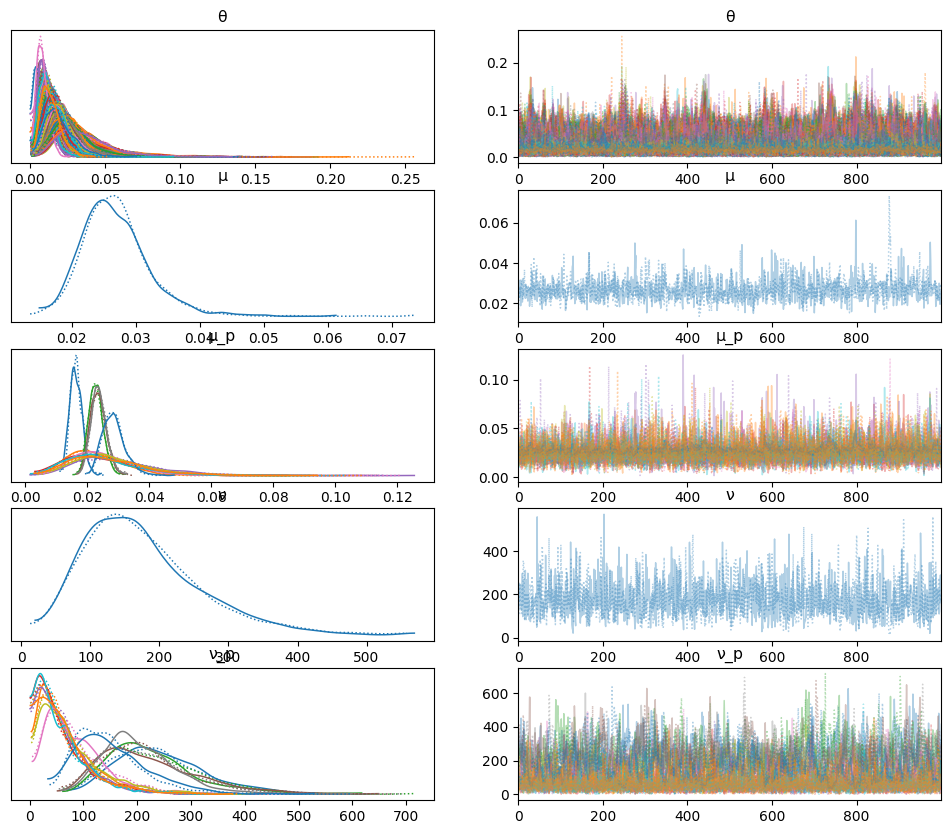

In [37]:
az.plot_trace(idata_stk)

In [38]:
az.rhat(idata_stk)

<xarray.Dataset> Size: 10kB
Dimensions:  (θ_dim_0: 572, pos: 12)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 5kB 0 1 2 3 4 5 6 7 ... 565 566 567 568 569 570 571
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    θ        (θ_dim_0) float64 5kB 1.0 1.001 1.004 0.9993 ... 1.003 1.0 1.002
    μ        float64 8B 1.005
    μ_p      (pos) float64 96B 1.003 1.002 1.014 1.001 ... 1.002 1.0 1.004 1.002
    ν        float64 8B 1.0
    ν_p      (pos) float64 96B 1.002 1.002 1.021 0.9995 ... 0.9997 1.005 1.001

array([<Axes: >], dtype=object)

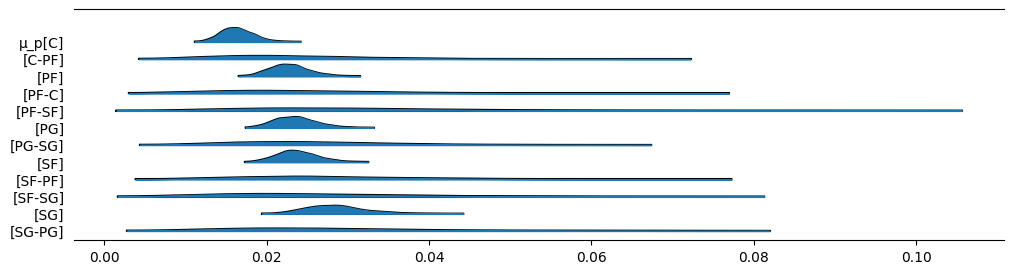

In [43]:
az.plot_forest(idata_stk, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

# Conclusion
I made a model that used a gamma distribution that modeled the way that stocks are distributed between positions in the NBA. As you can see from the forest plot above SG has the most stocks on average. Then, PG and SF are about equal. Then, C comes in at last. I'm ignoring the other positions because those are special positions with not a lot of players, so the model doesn't really know what to do with them. This is a very interesting thing and one conclusion we can draw from this is that in the 2023-24 NBA season guards and smaller players might have been a little bit more effective defensively as there defensive stats are greater.